## Example: Visualizing Seattle Bicycle Counts

As a more involved example of working with some time series data, let's take a look at bicycle counts on Seattle's [Fremont Bridge](http://www.openstreetmap.org/#map=17/47.64813/-122.34965).
This data comes from an automated bicycle counter, installed in late 2012, which has inductive sensors on the east and west sidewalks of the bridge.
The hourly bicycle counts can be downloaded from http://data.seattle.gov/; here is the [direct link to the dataset](https://data.seattle.gov/Transportation/Fremont-Bridge-Hourly-Bicycle-Counts-by-Month-Octo/65db-xm6k).

As of summer 2016, the CSV can be downloaded as follows:

In [3]:
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1956k    0 1956k    0     0  1040k      0 --:--:--  0:00:01 --:--:-- 1040k


Once this dataset is downloaded, we can use Pandas to read the CSV output into a ``DataFrame``.
We will specify that we want the Date as an index, and we want these dates to be automatically parsed:

In [5]:
import pandas as pd
data = pd.read_csv('FremontBridge.csv', index_col='Date', parse_dates=True)
data.head()

,Fremont Bridge Total,Fremont Bridge East Sidewalk,Fremont Bridge West Sidewalk
Date,,,
2012-10-03 00:00:00,13.0,4.0,9.0
2012-10-03 01:00:00,10.0,4.0,6.0
2012-10-03 02:00:00,2.0,1.0,1.0
2012-10-03 03:00:00,5.0,2.0,3.0
2012-10-03 04:00:00,7.0,6.0,1.0


For convenience, we'll further process this dataset by shortening the column names and adding a "Total" column:

In [7]:
data.columns = ['Total','West', 'East']
#data['Total'] = data.eval('West + East')

Now let's take a look at the summary statistics for this data:

In [8]:
data.dropna().describe()

,Total,West,East
count,62750.000000,62750.000000,62750.000000
mean,114.693163,52.726948,61.966215
std,145.818044,67.595710,90.692425
min,0.000000,0.000000,0.000000
25%,15.000000,7.000000,7.000000
50%,62.000000,29.000000,30.000000
75%,150.000000,71.000000,75.000000
max,1097.000000,698.000000,850.000000


### Visualizing the data

We can gain some insight into the dataset by visualizing it.
Let's start by plotting the raw data:

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn; seaborn.set()

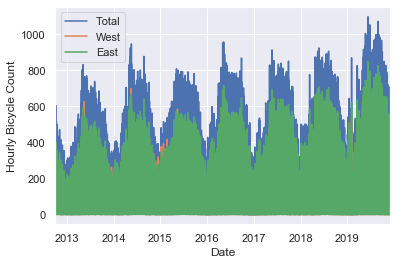

In [12]:
data.plot()
plt.ylabel('Hourly Bicycle Count');

The ~25,000 hourly samples are far too dense for us to make much sense of.
We can gain more insight by resampling the data to a coarser grid.
Let's resample by week:

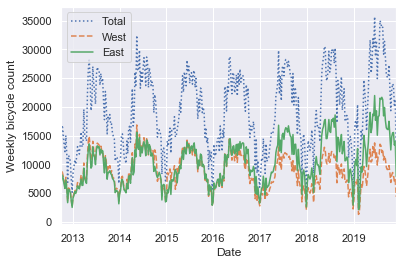

In [13]:
weekly = data.resample('W').sum()
weekly.plot(style=[':', '--', '-'])
plt.ylabel('Weekly bicycle count');

This shows us some interesting seasonal trends: as you might expect, people bicycle more in the summer than in the winter, and even within a particular season the bicycle use varies from week to week (likely dependent on weather; see [In Depth: Linear Regression](05.06-Linear-Regression.ipynb) where we explore this further).

Another way that comes in handy for aggregating the data is to use a rolling mean, utilizing the ``pd.rolling_mean()`` function.
Here we'll do a 30 day rolling mean of our data, making sure to center the window:

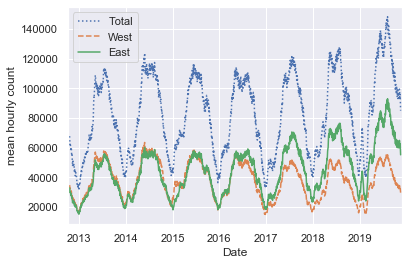

In [14]:
daily = data.resample('D').sum()
daily.rolling(30, center=True).sum().plot(style=[':', '--', '-'])
plt.ylabel('mean hourly count');

The jaggedness of the result is due to the hard cutoff of the window.
We can get a smoother version of a rolling mean using a window function–for example, a Gaussian window.
The following code specifies both the width of the window (we chose 50 days) and the width of the Gaussian within the window (we chose 10 days):

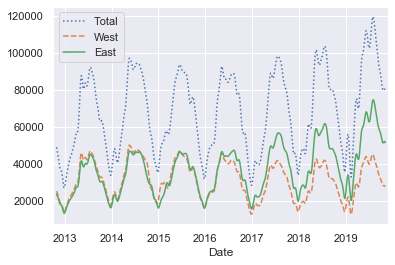

In [15]:
daily.rolling(50, center=True,
              win_type='gaussian').sum(std=10).plot(style=[':', '--', '-']);

### Digging into the data

While these smoothed data views are useful to get an idea of the general trend in the data, they hide much of the interesting structure.
For example, we might want to look at the average traffic as a function of the time of day.
We can do this using the GroupBy functionality discussed in [Aggregation and Grouping](03.08-Aggregation-and-Grouping.ipynb):

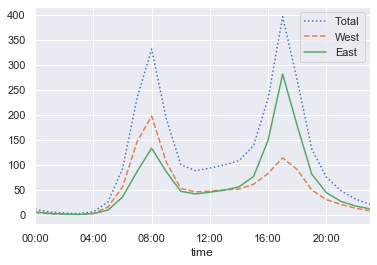

In [17]:
import numpy as np
by_time = data.groupby(data.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(xticks=hourly_ticks, style=[':', '--', '-']);

The hourly traffic is a strongly bimodal distribution, with peaks around 8:00 in the morning and 5:00 in the evening.
This is likely evidence of a strong component of commuter traffic crossing the bridge.
This is further evidenced by the differences between the western sidewalk (generally used going toward downtown Seattle), which peaks more strongly in the morning, and the eastern sidewalk (generally used going away from downtown Seattle), which peaks more strongly in the evening.

We also might be curious about how things change based on the day of the week. Again, we can do this with a simple groupby:

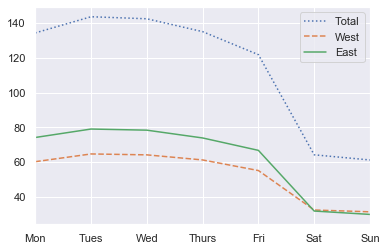

In [18]:
by_weekday = data.groupby(data.index.dayofweek).mean()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(style=[':', '--', '-']);

This shows a strong distinction between weekday and weekend totals, with around twice as many average riders crossing the bridge on Monday through Friday than on Saturday and Sunday.

With this in mind, let's do a compound GroupBy and look at the hourly trend on weekdays versus weekends.
We'll start by grouping by both a flag marking the weekend, and the time of day:

In [19]:
weekend = np.where(data.index.weekday < 5, 'Weekday', 'Weekend')
by_time = data.groupby([weekend, data.index.time]).mean()

Now we'll use some of the Matplotlib tools described in [Multiple Subplots](04.08-Multiple-Subplots.ipynb) to plot two panels side by side:

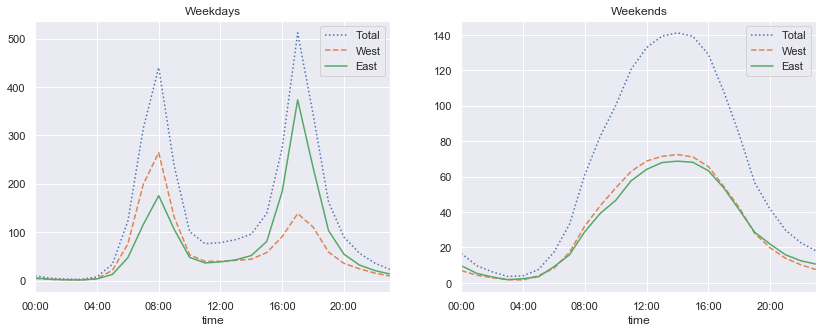

In [21]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, style=[':', '--', '-'])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, style=[':', '--', '-']);

The result is very interesting: we see a bimodal commute pattern during the work week, and a unimodal recreational pattern during the weekends.
It would be interesting to dig through this data in more detail, and examine the effect of weather, temperature, time of year, and other factors on people's commuting patterns; for further discussion, see my blog post ["Is Seattle Really Seeing an Uptick In Cycling?"](https://jakevdp.github.io/blog/2014/06/10/is-seattle-really-seeing-an-uptick-in-cycling/), which uses a subset of this data.
We will also revisit this dataset in the context of modeling in [In Depth: Linear Regression](05.06-Linear-Regression.ipynb).